In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# configure logging
import logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('Assignment1MicroarrayEpigeneticClock').setLevel(logging.DEBUG)
logging.getLogger('GlmNetEpigeneticClockTrainer').setLevel(logging.DEBUG)
logging.getLogger('download_file').setLevel(logging.DEBUG)

In [2]:
import os
from epigenetic_clock_assignment import download_file

data_dir = 'data/assignment1'
features_filepath = os.path.join(data_dir, 'GSE40279_average_beta.txt')
features_gz_filepath = os.path.join(data_dir, 'GSE40279_average_beta.txt.gz')

# download features file if does not exists
download_file(url='https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE40279&format=file&file=GSE40279%5Faverage%5Fbeta%2Etxt%2Egz',
             out_filepath=features_filepath, intermediate_gzip_filepath=features_gz_filepath)


DEBUG:download_file:file data/assignment1/GSE40279_average_beta.txt already exists; do not download again


In [3]:
%%time

import os
from epigenetic_clock_assignment import Assignment1MicroarrayEpigeneticClock, GlmNetEpigeneticClockTrainer

data_source = Assignment1MicroarrayEpigeneticClock(
        meta_filepath=os.path.join(data_dir, 'GSE40279_family.soft-MetaData.csv'),
        features_filepath=features_filepath
)

X, y = data_source.load()


DEBUG:Assignment1MicroarrayEpigeneticClock:load
DEBUG:Assignment1MicroarrayEpigeneticClock:joining based on ID
DEBUG:Assignment1MicroarrayEpigeneticClock:loaded


CPU times: user 18.9 s, sys: 3.11 s, total: 22 s
Wall time: 28.6 s


In [4]:
%%time

from epigenetic_clock_assignment import GlmNetEpigeneticClockTrainer

clock_trainer = GlmNetEpigeneticClockTrainer(
    n_parallel_jobs=2,
    n_cv_fold=3,
    # the weight of standard error used to determine lambda_best, 0 means use lambda_max (see glmnet.ElasticNet)
    std_error_weight_for_lambda_best=0.5,
    seed=42
)

X_train, X_test, y_train, y_test = clock_trainer.train_test_split(X, y, test_size=0.2)

hyperparameter_result, hyperparameter_stats, best_model = clock_trainer.hyperparameter_optimization(X_train=X_train, y_train=y_train, alpha_count=10 + 1)


DEBUG:GlmNetEpigeneticClockTrainer:starting hyperparameter optimization with alpha range [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.0...
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   27.7s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.1...
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   21.4s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.2...
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   23.0s finished
DEBUG:GlmNetEpigeneticClockTrainer:training with alpha 0.30000000000000004...
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   22.8s finished
D

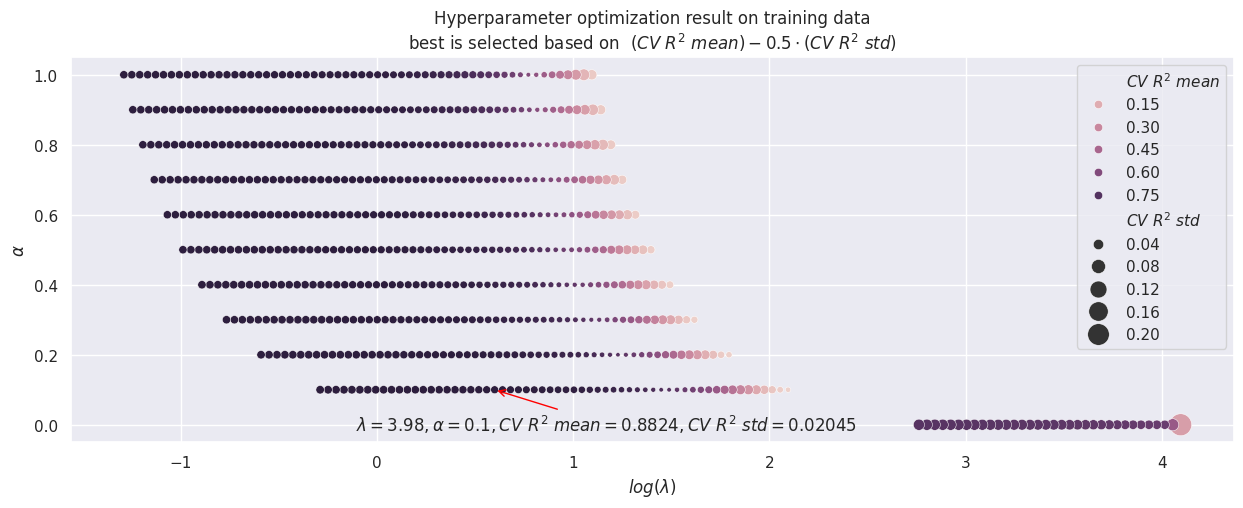

10

In [5]:
clock_trainer.plot_hyperparameter_optimization_result(hyperparameter_result=hyperparameter_result, hyperparameter_stats=hyperparameter_stats)
hyperparameter_stats
hyperparameter_stats.dtypes
a = [1,2,3]
int(hyperparameter_stats.iloc[-1]['model_index'])

# Predict using the best model

In [8]:
best_lambda = hyperparameter_result.lambd
best_alpha = hyperparameter_result.alpha

print('best_lambda', best_lambda, best_model.lambda_max_, best_model.lambda_best_ , best_model.cut_point)

# sanity check
assert best_model.alpha == best_alpha
assert best_model.lambda_best_ == best_lambda

# predict
y_pred = best_model.predict(X = X_test, lamb=best_lambda)


best_lambda 3.980115864775063 3.980115864775063 [7.63350506] 0.5


# Plot linear regression result

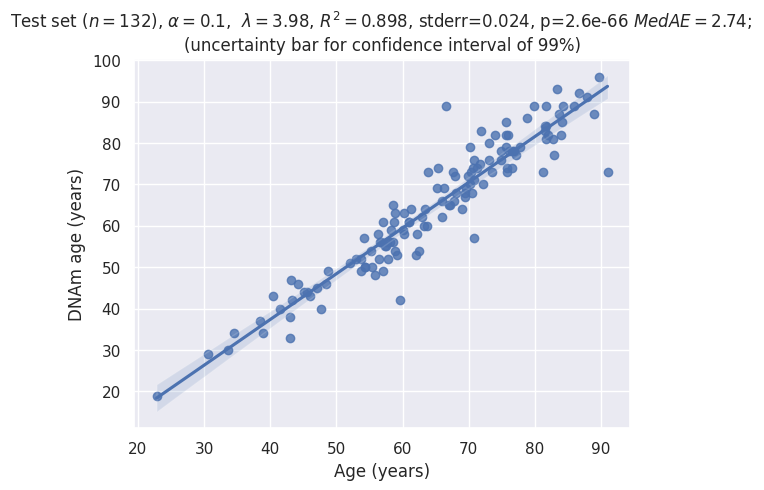

[[66.         67.71207784]
 [51.         52.07996437]
 [84.         81.67437314]
 [77.         77.20661827]
 [78.         76.7669216 ]
 [58.         62.23758143]
 [74.         75.80403963]
 [68.         69.4811257 ]
 [72.         69.83268391]
 [68.         68.09920069]
 [56.         56.73292864]
 [49.         57.02996811]
 [29.         30.59008112]
 [82.         82.05442431]
 [54.         55.18055838]
 [74.         71.1864593 ]
 [55.         57.31913624]
 [69.         66.23234138]
 [64.         63.34404707]
 [82.         75.87514703]
 [57.         54.1440562 ]
 [73.         81.25903562]
 [56.         56.6148953 ]
 [83.         81.56380661]
 [85.         84.14395531]
 [55.         57.44138748]
 [96.         89.68355352]
 [91.         87.81470258]
 [81.         81.750684  ]
 [49.         53.73504544]
 [52.         52.94698162]
 [82.         83.91620207]
 [54.         62.52241338]
 [42.         59.64942545]
 [47.         43.06801822]
 [73.         90.97487191]
 [89.         81.6412623 ]
 

In [9]:
stats = clock_trainer.calculate_statistics(y_true=y_test, y_pred=y_pred)
clock_trainer.plot_linear_regression_result(y_true=y_test, y_pred=y_pred, stats=stats, alpha=best_alpha, lamb=best_lambda)

import numpy as np
print(np.column_stack((y_test, y_pred)))

In [ ]:
# P


import numpy as np




model=best_model
print('n_lambda_', model.n_lambda_)
print('lambda_path_', model.lambda_path_, model.lambda_path_.shape)
print('coef_path_', model.coef_path_, model.coef_path_.shape)
print('coef_ for lambda_best', model.coef_, model.coef_.dtype, model.coef_.shape)
print('coef_ nonzero', np.count_nonzero(np.invert(np.isclose(model.coef_, 0, atol=np.finfo(model.coef_.dtype).tiny, rtol=0))))
print('intercept_ for lambda_best', model.intercept_)
print('intercept_path', model.intercept_path_, model.intercept_path_.shape)
print('cv_mean_score_', model.cv_mean_score_, model.cv_mean_score_.shape)
print('cv_standard_error_', model.cv_standard_error_)
print('lambda_max_', model.lambda_max_)
print('lambda_best_', model.lambda_best_)

In [ ]:
# TODO: 

# Feature importance based
# feature matrix
# glider-nel mint tanitottunk es min teszteltunk
# scatter plot, ahol sok pont van, ott pirosabb (hoterkep)


# delta age  pred - pred age
# delta age az colleral az eletkorral (fiatalokra gyakran lesz pozitiv , oregekre negativ)
# age acc. : prefictalt eletkorbol kivonjuk a regresszios egyenest -> az az erdekes, akik kilognak